# House Price Predictor

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader

In [5]:
# -----------------------------
# 1. Load the dataset
# -----------------------------
# Replace 'house_prices.csv' with the path to your dataset.
data = pd.read_csv('train.csv')
#data

In [6]:
# -----------------------------
# 2. Data Cleaning
# -----------------------------
# Select only numeric columns that have no missing data.
numeric_cols = data.select_dtypes(include=[np.number]).columns
clean_numeric_cols = [col for col in numeric_cols if data[col].isna().sum() == 0]
data_clean = data[clean_numeric_cols]

# Ensure that the target column 'price' is present.
if 'SalePrice' not in data_clean.columns:
    raise ValueError("The target column 'price' is not present in the complete numeric data.")

In [7]:
# -----------------------------
# 3. Feature Selection
# -----------------------------
# Compute the correlation matrix using only the cleaned numeric data.
corr_matrix = data_clean.corr()

# Compute absolute correlations of features with the target and drop the target itself.
target_corr = corr_matrix['SalePrice'].drop('SalePrice').abs().sort_values(ascending=False)

# Select only the top 4 features with the highest correlation with 'SalesPrice'
top4_features = target_corr.head(4).index
print("Selected top 4 features:", list(top4_features))

# Define input features (X) and target variable (y).
X = data_clean[top4_features].values
y = data_clean['SalePrice'].values.reshape(-1, 1)

Selected top 4 features: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']


In [8]:
# -----------------------------
# 4. Data Preprocessing
# -----------------------------
# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features to improve training stability.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Convert the numpy arrays to PyTorch tensors.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a TensorDataset and DataLoader for batch processing.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [10]:
# -----------------------------
# 5. Define the Neural Network Model
# -----------------------------
class HousePriceModel(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Output layer for regression
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HousePriceModel(input_dim=X_train.shape[1]).to(device)

In [11]:
# -----------------------------
# 6. Set Up Loss Function and Optimizer
# -----------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -----------------------------
# 7. Train the Model
# -----------------------------
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_dataset)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [10/1000], Loss: 41000475443.2000
Epoch [20/1000], Loss: 40376571658.2400
Epoch [30/1000], Loss: 38658284421.1200
Epoch [40/1000], Loss: 35608235130.8800
Epoch [50/1000], Loss: 31292118548.4800
Epoch [60/1000], Loss: 26094486405.1200
Epoch [70/1000], Loss: 20608791879.6800
Epoch [80/1000], Loss: 15502638776.3200
Epoch [90/1000], Loss: 11326187089.9200
Epoch [100/1000], Loss: 8331653652.4800
Epoch [110/1000], Loss: 6447198873.6000
Epoch [120/1000], Loss: 5369902100.4800
Epoch [130/1000], Loss: 4752907294.7200
Epoch [140/1000], Loss: 4330786048.0000
Epoch [150/1000], Loss: 3976219146.2400
Epoch [160/1000], Loss: 3643808655.3600
Epoch [170/1000], Loss: 3332254351.3600
Epoch [180/1000], Loss: 3045372200.9600
Epoch [190/1000], Loss: 2787239710.7200
Epoch [200/1000], Loss: 2564061849.6000
Epoch [210/1000], Loss: 2377042334.7200
Epoch [220/1000], Loss: 2226936901.1200
Epoch [230/1000], Loss: 2108704299.5200
Epoch [240/1000], Loss: 2013476441.6000
Epoch [250/1000], Loss: 1940715417.6000


In [12]:
# 8. Evaluate the Model
# -----------------------------
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor.to(device))
    test_loss = criterion(predictions, y_test_tensor.to(device)).item()
    print("Test Mean Squared Error:", test_loss)

# Optionally, to evaluate using scikit-learn's MSE:
predictions_np = predictions.cpu().numpy()
mse = mean_squared_error(y_test, predictions_np)
print("Test MSE (scikit-learn):", mse)
#Test Mean Squared Error: 935741376.0
#Test Mean Squared Error: 890287168.0
#Test MSE (scikit-learn): 890287040.0

Test Mean Squared Error: 925930560.0
Test MSE (scikit-learn): 925930560.0


In [13]:
model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor.to(device))
    train_loss = criterion(train_predictions, y_train_tensor.to(device)).item()
    train_rmse = np.sqrt(train_loss)
    print("Training RMSE:", train_rmse)

rmse = np.sqrt(test_loss)
print(f"Test RMSE: {rmse}")

#Bella's Result: Training RMSE: 37040.67904345167
#Test RMSE: 30354.362585961182

Training RMSE: 37073.64001551507
Test RMSE: 30429.10711802106


/tmp/ipykernel_113883/3042700335.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  errors = np.abs(predictions - y_test)


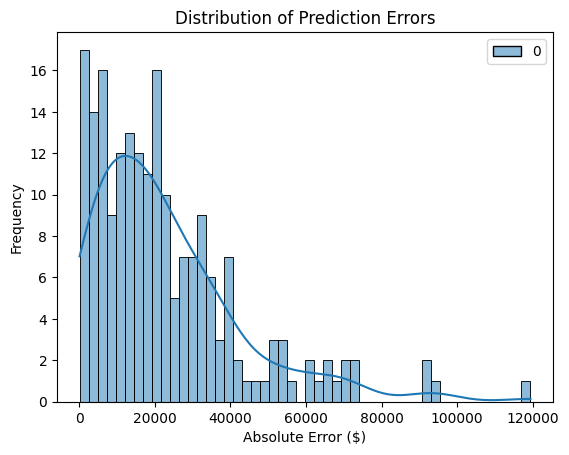

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

errors = np.abs(predictions - y_test)
sns.histplot(errors, bins=50, kde=True)
plt.xlabel("Absolute Error ($)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

In [15]:
# -----------------------------
# 9. Generate Predictions on New Test Data (test.csv)
# -----------------------------
# Load the new test data
test_data = pd.read_csv('test.csv')

# Ensure the test data contains the ID column and the same top4_features.
# For this example, assume the test file contains an "ID" column.
if 'Id' not in test_data.columns:
    raise ValueError("The test data must contain an 'ID' column.")

# It's assumed that the test data has at least the columns used in training.
# Use the same top4_features determined from the training set.
X_new = test_data[top4_features].values

# Apply the same scaling transformation using the previously fitted scaler.
X_new_scaled = scaler.transform(X_new)

# Convert to PyTorch tensor.
X_new_tensor = torch.tensor(X_new_scaled, dtype=torch.float32).to(device)

# Put the model in evaluation mode and generate predictions.
model.eval()
with torch.no_grad():
    new_predictions = model(X_new_tensor)
    
# Convert predictions to numpy array and flatten if necessary.
new_predictions_np = new_predictions.cpu().numpy().flatten()

# Create a DataFrame with IDs and their corresponding predicted sale prices.
predictions_df = pd.DataFrame({
    'ID': test_data['Id'],
    'SalePrice': new_predictions_np
})

# Save the DataFrame to a CSV file.
predictions_df.to_csv('predictions_original_architecture.csv', index=False)
print("Predictions saved to predictions_original_architecture.csv")


Predictions saved to predictions_original_architecture.csv
